In [1]:
import sys, os
from pathlib import Path
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

## Load flooding configuration file from local device or gcs

In [2]:
from ml4floods.models.config_setup import get_default_config
import pkg_resources

# Set filepath to configuration files
# config_fp = 'path/to/worldfloods_template.json'
config_fp = pkg_resources.resource_filename("ml4floods","models/configurations/worldfloods_template.json")

config = get_default_config(config_fp)

Loaded Config for experiment:  worldfloods_demo_test
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4cc_data_lake',
                       'channel_configuration': 'all',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': 'worldfloods',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]}

## Step 2: Setup Dataloader

In [3]:
config.experiment_name = 'training_flooding_rgbir_full_UNET'
config.data_params.channel_configuration = 'bgri'
config.data_params.window_size = [572,572]
config.data_params.batch_size = 32
# config.experiment_name = 'training_flooding_rgb'
# config.data_params.channel_configuration = 'rgb'
# config.data_params.window_size = [256,256]
# config.data_params.batch_size = 48
config.model_params.hyperparameters.channel_configuration = 'bgri'
config.model_params.hyperparameters.num_channels = 4
config.data_params.bucket_id = ""
config.data_params.num_workers = 64
config

{'experiment_name': 'training_flooding_rgbir_full_UNET',
 'seed': 12,
 'model_params': {'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 256,
   'metric_monitor': 'val_dice_loss',
   'channel_configuration': 'bgri',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'linear',
   'num_classes': 3,
   'max_epochs': 10,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 4},
  'train': True,
  'test': True},
 'data_params': {'loader_type': 'local',
  'num_workers': 64,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': '',
  'path_to_splits': 'worldfloods',
  'train_test_split_file': '2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json',
  'input_folder': 'S2

In [4]:
%%time

from ml4floods.models.dataset_setup import get_dataset

# config.data_params.batch_size = 96 # control this depending on the space on your GPU!
config.data_params.loader_type = 'local'
config.data_params.path_to_splits = "/mnt/d/Flooding/worldfloods_v1_sample" # local folder to download the data
config.data_params.train_test_split_file = "/mnt/d/Flooding/train_test_split_local.json"

config.data_params["download"] = {"train": True, "val": True, "test": True} # download only test data
# config.data_params.train_test_split_file = "2_PROD/2_Mart/worldfloods_v1_0/train_test_split.json" # use this to train with all the data

# If files are not in config.data_params.path_to_splits this will trigger the download of the products.
dataset = get_dataset(config.data_params)

train 40369  tiles
val 256  tiles
test 11  tiles
CPU times: user 3.8 s, sys: 6 s, total: 9.8 s
Wall time: 2.79 s


## Verfify data loader

#### Verify training data
Data format here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [5]:
train_dl = dataset.train_dataloader()
train_dl_iter = iter(train_dl)
print(len(train_dl_iter))
batch_train = next(train_dl_iter)

batch_train["image"].shape, batch_train["mask"].shape

1262


(torch.Size([32, 4, 572, 572]), torch.Size([32, 1, 572, 572]))

Verify validation data

In [6]:
val_dl = dataset.val_dataloader()

val_dl_iter = iter(val_dl)
print(len(val_dl_iter))
batch_val = next(val_dl_iter)

# batch_val["image"].shape, batch_val["mask"].shape

8


In [7]:
test_dl = dataset.test_dataloader()

test_dl_iter = iter(test_dl)
print(len(test_dl_iter))

batch_test = next(test_dl_iter)
# batch_test["image"].shape, batch_test["mask"].shape

11


### Plot batch by using ml4flood model 
check detail here: https://github.com/spaceml-org/ml4floods/blob/891fe602880586e7ac821d2f282bf5ec9d4c0795/ml4floods/data/worldfloods/dataset.py#L106

In [8]:
import importlib
import matplotlib.pyplot as plt
from models import flooding_model
flooding_model = importlib.reload(flooding_model)

# batch_train_rgb = flooding_model.batch_to_unnorm_rgb(batch_train["image"])
# # batch_train_rgb.shape
# plt.imshow(batch_train_rgb[2])
# plt.show()

# batch_train_rgb_mask = flooding_model.batch_mask_to_rgb(batch_train["mask"])
# plt.imshow(batch_train_rgb_mask[2])
# plt.colorbar()
# plt.show()


## Step 3: Setup Model

In [9]:
 # folder to store the trained model (it will create a subfolder with the name of the experiment)
config.model_params

{'model_folder': 'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 256,
  'metric_monitor': 'val_dice_loss',
  'channel_configuration': 'bgri',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'linear',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 4},
 'train': True,
 'test': True}

In [10]:
config.model_params.model_folder = "train_models" 
os.makedirs("train_models", exist_ok=True)
config.model_params.test = False
config.model_params.train = True
config.model_params.hyperparameters.model_type = "full_unet" # Currently implemented: simplecnn, unet, linear, full_unet
config.model_params.hyperparameters.max_tile_size = 572
# config.model_params.hyperparameters.max_tile_size = 256
config.model_params.hyperparameters.num_channels = 4
config.model_params.hyperparameters.metric_monitor = "val_bce_loss" # config loss metric val_dice_loss
config.model_params

{'model_folder': 'train_models',
 'model_version': 'v1',
 'hyperparameters': {'max_tile_size': 572,
  'metric_monitor': 'val_bce_loss',
  'channel_configuration': 'bgri',
  'label_names': ['land', 'water', 'cloud'],
  'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
  'model_type': 'full_unet',
  'num_classes': 3,
  'max_epochs': 10,
  'val_every': 1,
  'lr': 0.0001,
  'lr_decay': 0.5,
  'lr_patience': 2,
  'early_stopping_patience': 4,
  'num_channels': 4},
 'train': True,
 'test': False}

In [11]:
import copy
from models.flooding_model import WorldFloodsModel, DistilledTrainingModel, WorldFloodsModel0
importlib.reload(flooding_model)
simple_model_params = copy.deepcopy(config.model_params)
# simple_model_params['hyperparameters']['model_type']="full_unet"

# model = DistilledTrainingModel(config.model_params, simple_model_params)
model = WorldFloodsModel0(config.model_params)
net = model.network
net

FullUNet(
  (inc): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [12]:
# Compuatation complexity of network
from ptflops import get_model_complexity_info
macs, params = get_model_complexity_info(net, (config.model_params.hyperparameters.num_channels, config.model_params.hyperparameters.max_tile_size, config.model_params.hyperparameters.max_tile_size), as_strings=True, print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

FullUNet(
  17.268 M, 100.000% Params, 199.497 GMac, 100.000% MACs, 
  (inc): Sequential(
    0.039 M, 0.228% Params, 12.899 GMac, 6.466% MACs, 
    (0): Conv2d(0.002 M, 0.014% Params, 0.775 GMac, 0.388% MACs, 4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0.0 M, 0.000% Params, 0.021 GMac, 0.010% MACs, inplace=True)
    (2): Conv2d(0.037 M, 0.214% Params, 12.082 GMac, 6.056% MACs, 64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(0.0 M, 0.000% Params, 0.021 GMac, 0.010% MACs, inplace=True)
  )
  (down1): Down(
    0.222 M, 1.285% Params, 18.197 GMac, 9.121% MACs, 
    (maxpool_conv): Sequential(
      0.222 M, 1.285% Params, 18.197 GMac, 9.121% MACs, 
      (0): MaxPool2d(0.0 M, 0.000% Params, 0.021 GMac, 0.010% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        0.222 M, 1.285% Params, 18.176 GMac, 9.111% MACs, 
        (double_conv): Sequential(
          0.222 M, 1.285% Params, 18.176 G

In [13]:
setup_weights_and_biases = False
if setup_weights_and_biases:
    import wandb
    from pytorch_lightning.loggers import WandbLogger

    # UNCOMMENT ON FIRST RUN TO LOGIN TO Weights and Biases (only needs to be done once)
    # wandb.login()
    # run = wandb.init()

    # Specifies who is logging the experiment to wandb
    config['wandb_entity'] = 'ml4floods'
    # Specifies which wandb project to log to, multiple runs can exist in the same project
    config['wandb_project'] = 'worldfloods-notebook-demo-project'

    wandb_logger = WandbLogger(
        name=config.experiment_name,
        project=config.wandb_project, 
        entity=config.wandb_entity
    )
else:
    wandb_logger = None

In [14]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

experiment_path = f"{config.model_params.model_folder}/{config.experiment_name}"

checkpoint_callback = ModelCheckpoint(
    dirpath=f"{experiment_path}/checkpoint",
    save_top_k=True,
    verbose=True,
    monitor='val_bce_loss',
    mode='min',
#     prefix=''
)
# original monitor='val_dice_loss'

early_stop_callback = EarlyStopping(
    monitor='val_bce_loss',
    patience=10,
    strict=False,
    verbose=False,
    mode='min'
)
# original monitor='val_dice_loss'

callbacks = [checkpoint_callback, early_stop_callback]

print(f"The trained model will be stored in {config.model_params.model_folder}/{config.experiment_name}")

The trained model will be stored in train_models/training_flooding_rgbir_full_UNET


In [15]:
from pytorch_lightning import Trainer

config.gpus = 4 # which gpu to use

# config.gpus = None # to not use GPU

config.model_params.hyperparameters.max_epochs = 40 # train for maximum 4 epochs

# trainer = Trainer(
#     fast_dev_run=False,
#     logger=wandb_logger,
#     callbacks=callbacks,
#     default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
#     accumulate_grad_batches=1,
#     gradient_clip_val=0.0,
#     auto_lr_find=False,
#     benchmark=False,
#     distributed_backend=None,
#     gpus=config.gpus,
#     max_epochs=config.model_params.hyperparameters.max_epochs,
#     check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
#     log_gpu_memory=False,
#     resume_from_checkpoint='./train_models/training_flooding_rgb/checkpoint/epoch=29-step=182039.ckpt',
#     accelerator='dp'
# )

trainer = Trainer(
    fast_dev_run=False,
    logger=wandb_logger,
    callbacks=callbacks,
    default_root_dir=f"{config.model_params.model_folder}/{config.experiment_name}",
    accumulate_grad_batches=1,
    gradient_clip_val=0.0,
    auto_lr_find=False,
    benchmark=False,
    gpus=config.gpus,
    max_epochs=config.model_params.hyperparameters.max_epochs,
    check_val_every_n_epoch=config.model_params.hyperparameters.val_every,
    log_gpu_memory=False,
    accelerator='dp'
)
# config
# https://wandb.ai/wandb/wandb-lightning/reports/Multi-GPU-Training-Using-PyTorch-Lightning--VmlldzozMTk3NTk

/home/smc/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:286: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  rank_zero_deprecation(
/home/smc/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:33: LightningDeprecationWarning: Setting `log_gpu_memory` with the trainer flag is deprecated in v1.5 and will be removed in v1.7. Please monitor GPU stats with the `DeviceStatsMonitor` callback directly instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dataset)

/home/smc/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type     | Params
-------------------------------------
0 | network | FullUNet | 17.3 M
-------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.071    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/smc/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 152 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1261: val_bce_loss reached 1.30198 (best 1.30198), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=0-step=1261.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 2523: val_bce_loss reached 1.28152 (best 1.28152), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=1-step=2523.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 3785: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 5047: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 6309: val_bce_loss reached 1.11397 (best 1.11397), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=4-step=6309.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 7571: val_bce_loss reached 1.09131 (best 1.09131), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=5-step=7571.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 8833: val_bce_loss reached 1.05636 (best 1.05636), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=6-step=8833.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 10095: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 11357: val_bce_loss reached 1.02347 (best 1.02347), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=8-step=11357.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 12619: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 13881: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 15143: val_bce_loss was not in top True


Epoch    12: reducing learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 16405: val_bce_loss reached 0.92347 (best 0.92347), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=12-step=16405.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 17667: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 18929: val_bce_loss reached 0.84566 (best 0.84566), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=14-step=18929.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 20191: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 21453: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 22715: val_bce_loss was not in top True


Epoch    18: reducing learning rate of group 0 to 2.5000e-05.


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 23977: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 25239: val_bce_loss reached 0.79941 (best 0.79941), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=19-step=25239.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 26501: val_bce_loss reached 0.78432 (best 0.78432), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=20-step=26501.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 27763: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 29025: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 30287: val_bce_loss reached 0.74490 (best 0.74490), saving model to "/home/smc/Projects/satellite-knowledge-distillation/train_models/training_flooding_rgbir_full_UNET/checkpoint/epoch=23-step=30287.ckpt" as top True


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 31549: val_bce_loss was not in top True


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 32811: val_bce_loss was not in top True


In [25]:
import torch
# Run inference on the images shown before

logits = model(batch_train["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([32, 3, 572, 572])
Shape of probs: torch.Size([32, 3, 572, 572])
Shape of prediction: torch.Size([32, 572, 572])


In [26]:
config.model_params.max_tile_size = config.model_params.hyperparameters.max_tile_size
config

{'experiment_name': 'training_flooding_rgbir_full_UNET',
 'seed': 12,
 'model_params': {'model_folder': 'train_models',
  'model_version': 'v1',
  'hyperparameters': {'max_tile_size': 572,
   'metric_monitor': 'val_bce_loss',
   'channel_configuration': 'bgri',
   'label_names': ['land', 'water', 'cloud'],
   'weight_per_class': [1.93445299, 36.60054169, 2.19400729],
   'model_type': 'full_unet',
   'num_classes': 3,
   'max_epochs': 40,
   'val_every': 1,
   'lr': 0.0001,
   'lr_decay': 0.5,
   'lr_patience': 2,
   'early_stopping_patience': 4,
   'num_channels': 4},
  'train': True,
  'test': False,
  'max_tile_size': 572},
 'data_params': {'loader_type': 'local',
  'num_workers': 64,
  'filter_windows': {'version': 'v1', 'threshold_clouds': 0.5, 'apply': False},
  'download': {'train': True, 'val': True, 'test': True},
  'bucket_id': '',
  'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_sample',
  'train_test_split_file': '/mnt/d/Flooding/train_test_split_local.json',
  'input_fol

Getting model inference function
Max tile size: 572


100%|██████████████████████████████████████████████████████████| 8/8 [02:22<00:00, 17.81s/it]


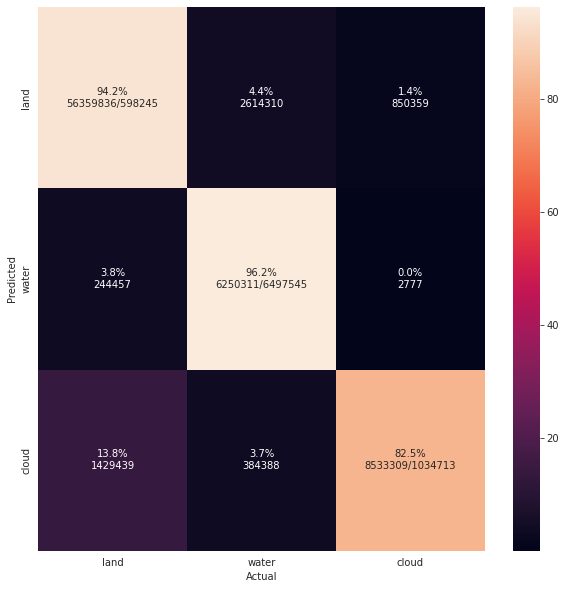

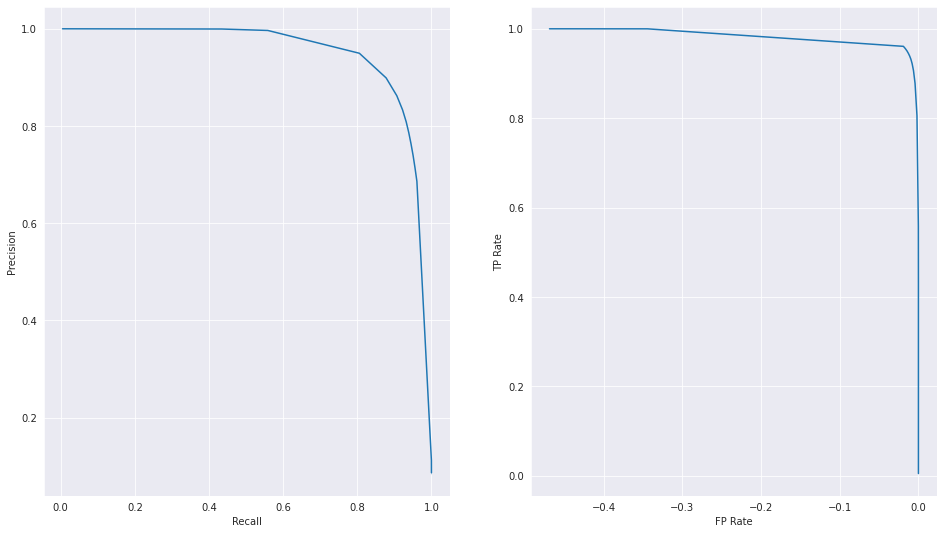

Per Class IOU {
    "cloud": 0.7618840863866309,
    "land": 0.9164439251030594,
    "water": 0.6581877696265417
}


In [27]:
# os.environ["CUDA_VISIBLE_DEVICES"]=""

import torch
import numpy as np
from ml4floods.models.utils import metrics
from ml4floods.models.model_setup import get_model_inference_function
import pandas as pd

# model.to("cuda")
inference_function = get_model_inference_function(model, config, apply_normalization=False, activation="softmax")

# config.data_params.batch_size = 4
# print(config.data_params)
# dataset2 = get_dataset(config.data_params)
dl = dataset.val_dataloader() # pytorch Dataloader

# Otherwise fails when reading test dataset from remote bucket
# torch.set_num_threads(1)

thresholds_water = [0,1e-3,1e-2]+np.arange(0.5,.96,.05).tolist() + [.99,.995,.999]

mets = metrics.compute_metrics(
    dl,
    inference_function, 
    thresholds_water=thresholds_water, 
    plot=False, convert_targets=False)

label_names = ["land", "water", "cloud"]
metrics.plot_metrics(mets, label_names)

In [28]:
if hasattr(dl.dataset, "image_files"):
    cems_code = [os.path.basename(f).split("_")[0] for f in dl.dataset.image_files]
else:
    cems_code = [os.path.basename(f.file_name).split("_")[0] for f in dl.dataset.list_of_windows]

iou_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_iou,
                                                    label_names=[f"IoU_{l}"for l in ["land", "water", "cloud"]]))

recall_per_code = pd.DataFrame(metrics.group_confusion(mets["confusions"],cems_code, metrics.calculate_recall,
                                                       label_names=[f"Recall_{l}"for l in ["land", "water", "cloud"]]))

join_data_per_code = pd.merge(recall_per_code,iou_per_code,on="code")
join_data_per_code = join_data_per_code.set_index("code")
join_data_per_code = join_data_per_code*100
print(f"Mean values across flood events: {join_data_per_code.mean(axis=0).to_dict()}")
join_data_per_code

Mean values across flood events: {'Recall_land': 92.95812184664622, 'Recall_water': 94.50752822740476, 'Recall_cloud': 71.26913516084183, 'IoU_land': 91.09628863568729, 'IoU_water': 50.01816171115368, 'IoU_cloud': 65.61362888462702}


,Recall_land,Recall_water,Recall_cloud,IoU_land,IoU_water,IoU_cloud
code,,,,,,
EMSR271,86.683799,99.037083,87.103200,86.409669,36.023469,79.937859
EMSR279,90.629397,91.427112,81.480045,83.592825,41.066987,75.241276
EMSR280,97.386019,96.980582,74.102745,96.933083,82.788535,66.597398
EMSR287,96.582215,91.768107,0.356718,96.326211,39.875435,0.351288
RS2,89.552833,97.069923,89.965088,87.680923,40.705574,82.991153
ST1,96.914468,90.762363,94.607015,95.635021,59.648971,88.562799


In [29]:
import torch
from pytorch_lightning.utilities.cloud_io import atomic_save
from ml4floods.models.config_setup import save_json

# Save in the cloud and in the wandb logger save dir
atomic_save(model.state_dict(), f"{experiment_path}/model_full_rgbir_unet_epoch_{config.model_params.hyperparameters.max_epochs}.pt")
# Save cofig file in experiment_path
config_file_path = f"{experiment_path}/config_full_rgbir_epoch_{config.model_params.hyperparameters.max_epochs}.json"
# save_json(config, f"{experiment_path}/config_full_rgb_epoch_{config.model_params.hyperparameters.max_epochs}.json")
import json
with open(config_file_path, 'w') as f:
    json.dump(config, f)

In [30]:
if setup_weights_and_biases:
    torch.save(model.state_dict(), os.path.join(wandb_logger.save_dir, f"model_full_rgbir_unet_epoch_{config.model_params.hyperparameters.max_epochs}.pt"))
    wandb.save(os.path.join(wandb_logger.save_dir, f"model_rgbir_full_unet_epoch_{config.model_params.hyperparameters.max_epochs}.pt")) # Copy weights to weights and biases server
    wandb.finish()

In [31]:
# Run inference on the images shown before

logits = model(batch_val["image"].to(model.device))
print(f"Shape of logits: {logits.shape}")
probs = torch.softmax(logits, dim=1)
print(f"Shape of probs: {probs.shape}")
prediction = torch.argmax(probs, dim=1).long().cpu()
print(f"Shape of prediction: {prediction.shape}")

Shape of logits: torch.Size([32, 3, 572, 572])
Shape of probs: torch.Size([32, 3, 572, 572])
Shape of prediction: torch.Size([32, 572, 572])


(4, 1, 1)
(4, 1, 1)


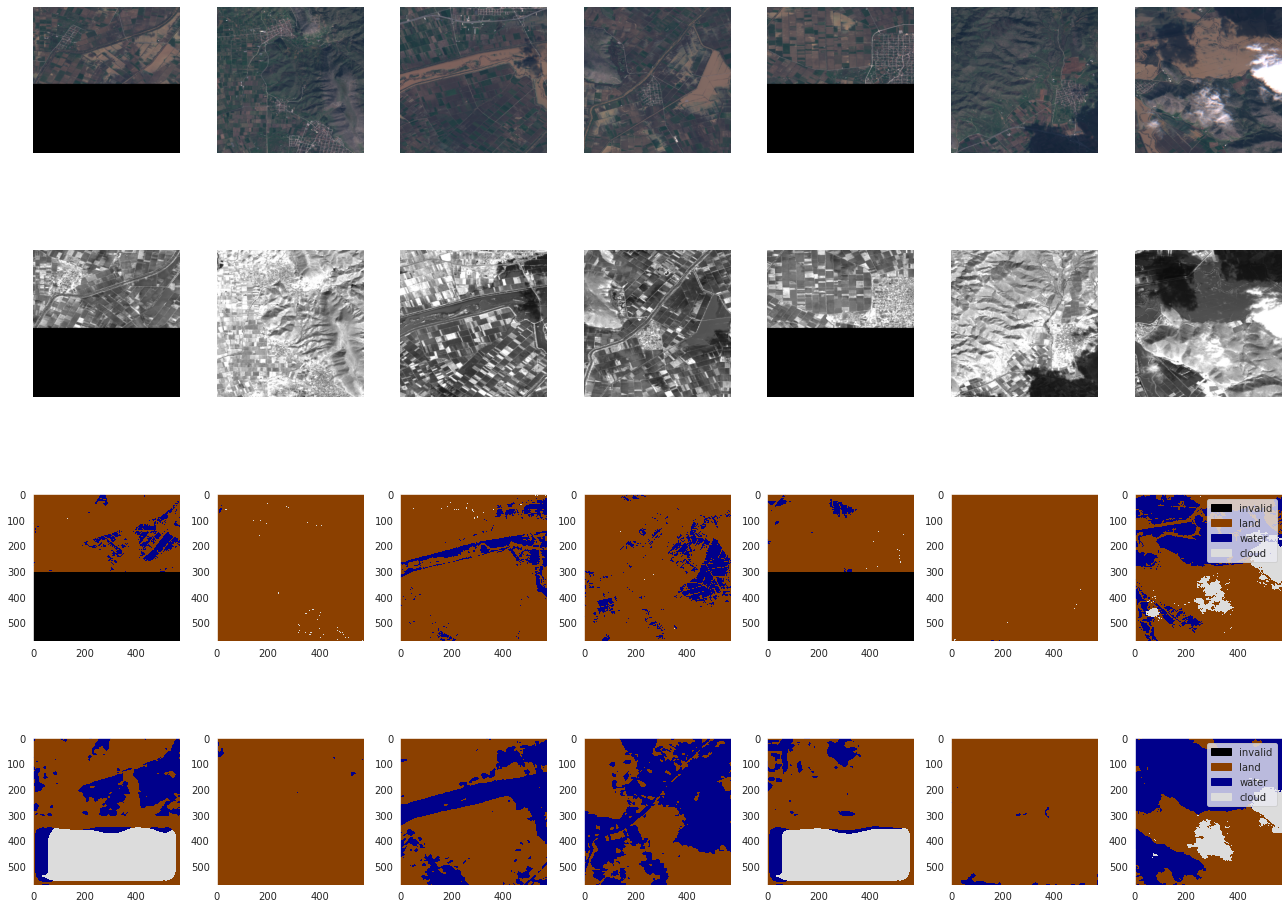

In [33]:
n_image_start=7
n_images=14
count=int(n_images-n_image_start)
fig, axs = plt.subplots(4, count, figsize=(18,14),tight_layout=True)
importlib.reload(flooding_model)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",axs=axs[0],max_clip_val=3500.)
flooding_model.plot_batch(batch_val["image"][n_image_start:n_images],channel_configuration="bgri",bands_show=["B8","B8", "B8"],axs=axs[1],max_clip_val=3500.)
# flooding_model.plot_batch(batch_val["image"][:n_images],bands_show=["B11","B8", "B4"],axs=axs[1],max_clip_val=4500.)
flooding_model.plot_batch_output_v1(batch_val["mask"][n_image_start:n_images, 0],axs=axs[2], show_axis=True)
flooding_model.plot_batch_output_v1(prediction[n_image_start:n_images] + 1,axs=axs[3], show_axis=True)

for ax in axs.ravel():
    ax.grid(False)